<a href="https://colab.research.google.com/github/Phatdat01/GAN/blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load dữ liệu mnist
from tensorflow.keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11501568/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


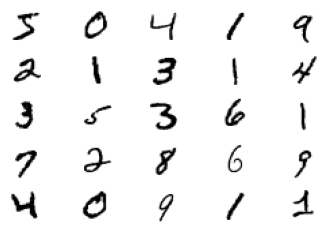

In [ ]:
import matplotlib.pyplot as plt

# plot images from the training dataset
def _plot(X):
	for i in range(25):
		# define subplot
		plt.subplot(5, 5, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i], cmap='gray_r')
	plt.show()
 
_plot(trainX[:25, :])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


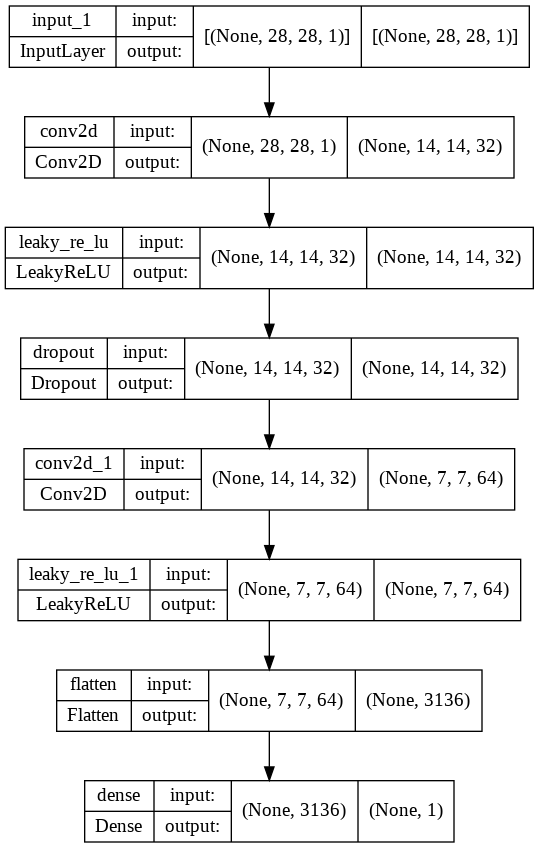

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, LeakyReLU, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

def _discriminator():
  # Khai báo các layers
  inpt = Input(shape=(28, 28, 1))
  conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same')(inpt)
  act_leak1 = LeakyReLU(alpha=0.3)(conv1)
  dropout = Dropout(0.4)(act_leak1)
  conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same')(dropout)
  act_leak2 = LeakyReLU(alpha=0.3)(conv2)
  flat = Flatten()(act_leak2)
  den = Dense(1, activation='sigmoid')(flat)
  # Khởi tạo model
  model = Model(inputs = [inpt], outputs = [den])
  # Compile với optimizer
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

discriminator = _discriminator()
plot_model(discriminator, show_shapes=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


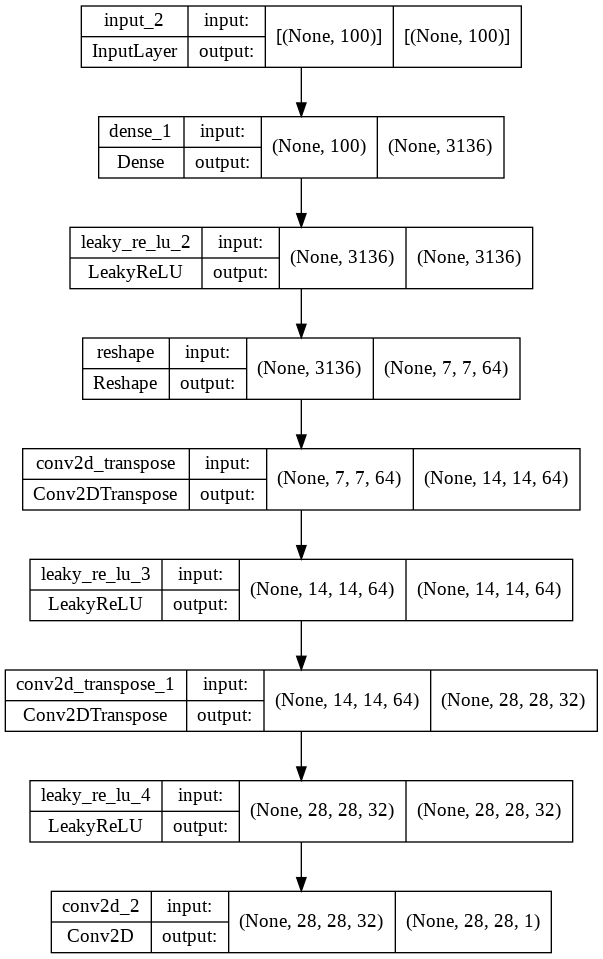

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose

def _generator(noise_size = 100):
  n_units = 64*7*7
  inpt = Input(shape=(noise_size))
  den1 = Dense(n_units)(inpt)
  act_leak1 = LeakyReLU(alpha=0.3)(den1)
  reshape = Reshape((7,7,64))(act_leak1)
  con2DTran1 = Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')(reshape)
  act_leak2 = LeakyReLU(alpha=0.3)(con2DTran1)
  con2DTran2 = Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')(act_leak2)
  act_leak3 = LeakyReLU(alpha=0.3)(con2DTran2)
  con = Conv2D(filters=1, kernel_size=(28, 28), activation='sigmoid', padding='same')(act_leak3)

  # Khởi tạo model
  model = Model(inputs = [inpt], outputs = [con])
  # Compile với optimizer
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

generator = _generator(noise_size = 100)
plot_model(generator, show_shapes=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


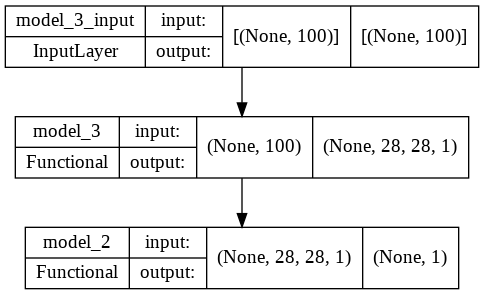

In [ ]:
from tensorflow.keras.models import Sequential

def _gan(g_model, d_model):
  # Đóng băng weight của discriminator
	d_model.trainable = False
	# Khởi tạo model GAN
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Khai báo số chiều của noise véc tơ input của generator.
latent_dim = 100
# Khởi tạo discriminator và generatator model
d_model = _discriminator()
g_model = _generator(latent_dim)
# Khởi tạo GAN model
gan_model = _gan(g_model, d_model)
plot_model(gan_model, show_shapes=True)

In [ ]:
def _normalize():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

In [ ]:
import numpy as np

# Hàm sinh batch input là noise véc tơ cho generator
def generate_latent_points(latent_dim, n_samples):
	# khởi tạo input ngẫu nhiên
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape về batch
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 

# Hàm sinh batch cho fake sample, nhãn của fake sample là 0
def generate_fake_samples(g_model, latent_dim, n_samples):
	# sinh batch là các noise véc tơ
	x_input = generate_latent_points(latent_dim, n_samples)
	# dự báo outputs từ g_model
	X = g_model.predict(x_input)
	# khởi tạo y = 0 với nhãn fake
	y = np.zeros((n_samples, 1))
	return X, y
  
def generate_real_samples(dataset, n_samples):
	# lựa chọn index ngẫu nhiên để lựa chọn batch
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# trích suất các ảnh từ dataset
	X = dataset[ix]
	# khởi tạo y = 1 với nhãn real
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
# đánh giá accuracy của discriminator trên cả tập real và tập fake
def summarize_performance(epoch, gan_model, X_real, y_real, X_fake, y_fake):
	_, acc_real = gan_model.layers[1].evaluate(X_real, y_real, verbose=0)
	_, acc_fake = gan_model.layers[1].evaluate(X_fake, y_fake, verbose=0)
	# thống kê discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, k=2):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # Huấn luyện mô hình trên các epochs
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      if j % k == 0:
        # Step 1: Huấn luyện trên discriminator
        gan_model.layers[0].trainable = False
        gan_model.layers[1].trainable = True
        # Khởi tạo batch huấn luyện trong đó có 1/2 batch là real và 1/2 batch là fake
        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_fake_samples(gan_model.layers[0], latent_dim, half_batch)
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
        d_loss, _ = gan_model.layers[1].train_on_batch(X, y)
        print('>%d, %d/%d, d=%.3f' % (i+1, j+1, bat_per_epo, d_loss))
      
      # Step 2: Huấn luyện trên generator
      # Khởi tạo batch noise
      X_gan = generate_latent_points(latent_dim, n_batch)
      # Những dữ liệu noise này giả định là đã đánh lừa được discriminator nên được gán nhãn là 1
      y_gan = np.ones((n_batch, 1))
      # huấn luyện generator thông qua gan_model
      gan_model.layers[0].trainable = True
      gan_model.layers[1].trainable = False
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # Loss function trên discriminator, generator
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      # Đánh giá mô hình:
      summarize_performance(j, gan_model, X_real, y_real, X_fake, y_fake)  

In [ ]:
# train model
dataset = _normalize()
train(g_model, d_model, gan_model, dataset, latent_dim)


Streaming output truncated to the last 5000 lines.
>92, 107/234, d=0.680
>92, 107/234, d=0.680, g=0.738
>Accuracy real: 34%, fake: 99%
>92, 108/234, d=0.680, g=0.762
>Accuracy real: 34%, fake: 99%
>92, 109/234, d=0.683
>92, 109/234, d=0.683, g=0.725
>Accuracy real: 47%, fake: 89%
>92, 110/234, d=0.683, g=0.734
>Accuracy real: 47%, fake: 89%
>92, 111/234, d=0.676
>92, 111/234, d=0.676, g=0.747
>Accuracy real: 34%, fake: 98%
>92, 112/234, d=0.676, g=0.734
>Accuracy real: 34%, fake: 98%
>92, 113/234, d=0.672
>92, 113/234, d=0.672, g=0.764
>Accuracy real: 38%, fake: 96%
>92, 114/234, d=0.672, g=0.732
>Accuracy real: 38%, fake: 96%
>92, 115/234, d=0.679
>92, 115/234, d=0.679, g=0.739
>Accuracy real: 35%, fake: 98%
>92, 116/234, d=0.679, g=0.739
>Accuracy real: 35%, fake: 98%
>92, 117/234, d=0.698
>92, 117/234, d=0.698, g=0.688
>Accuracy real: 72%, fake: 65%
>92, 118/234, d=0.698, g=0.687
>Accuracy real: 72%, fake: 65%
>92, 119/234, d=0.676
>92, 119/234, d=0.676, g=0.661
>Accuracy real: 88%,

In [ ]:
gan_model.save('gan_mnist.h5')

In [ ]:
# đánh giá accuracy của discriminator trên cả tập real và tập fake
def summarize_performance(epoch, gan_model, X_real, y_real, X_fake, y_fake):
	_, acc_real = gan_model.layers[1].evaluate(X_real, y_real, verbose=0)
	_, acc_fake = gan_model.layers[1].evaluate(X_fake, y_fake, verbose=0)
	# thống kê discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))


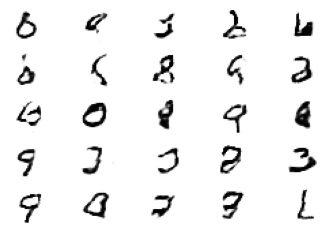

In [ ]:
X_eval, y_eval = generate_fake_samples(g_model=gan_model.layers[0], latent_dim=100, n_samples=25)

_plot(X_eval[:, :, :, 0])